In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
import itertools
from IPython.display import HTML, Math, Latex, Markdown, display

Func = namedtuple('Func' , 'func q p', defaults=('usual',None,None))

In [14]:
w = [0.6, 0.4]
a = [[2, 500], [28, 390], [18, 480]]

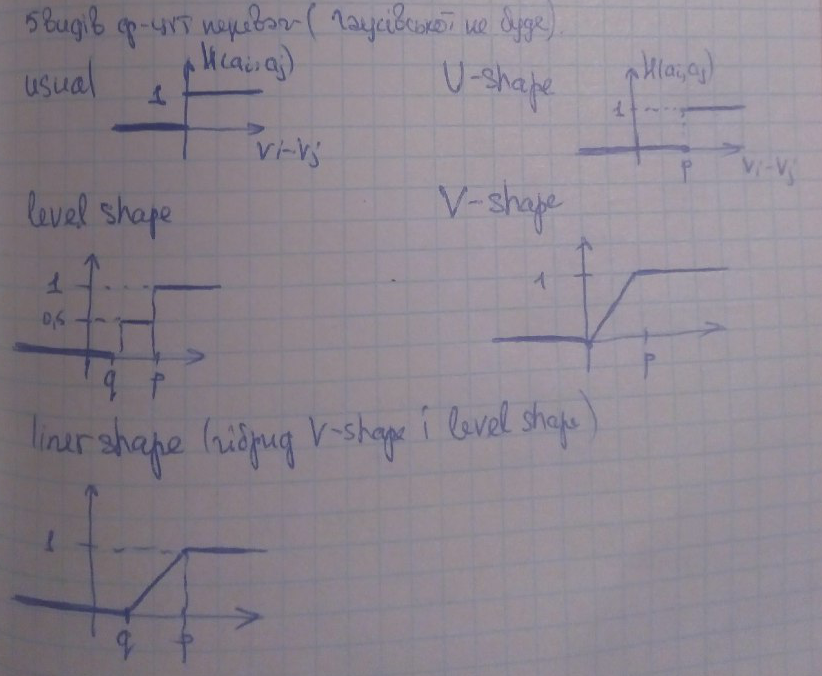

In [13]:
"""
possible ways to call different methods

    Func('linear', 5, 15),       # has q and p
    Func('level', 50, 100),      # has q and p 
    Func(func='u_shape', p=15),  # has p  
    Func(func='v_shape', p=15),  # has p  
    Func('usual'),   
"""

f = [
    Func('linear', 5, 15),       # has q and p
    Func('level', 50, 100),      # has q and p 
#     Func(func='u_shape', p=15),  # has p  
#     Func(func='v_shape', p=15),  # has p  
#     Func('usual'),               # no p and q
]

In [3]:
A = pd.DataFrame(a, 
                 index=[f"$a_{x+1}$" for x in range(len(a))],  
                 columns=[f"$C_{x+1}$" for x in range(len(w))])
A

,$C_1$,$C_2$
$a_1$,2,500
$a_2$,28,390
$a_3$,18,480


In [4]:
class Funcs():
    def __init__(self, a_i, a_j, params):
        self.a_i = a_i
        self.a_j = a_j
        self.method = params['func']
        del params['func']
        self.params = params
        
        
    def __call__(self):
        return self._methods(self.method)(self)

    def _methods(self, name):
        """ activators wrapper """
        methods = {name.replace('method_', ''): code
              for name, code in self.__class__.__dict__.items()
              if name.startswith('method_')
        } 
        return methods.get(name, None)

    def method_usual(self): 
        return 1 if self.a_i - self.a_j > 0 else 0
        
        
    def method_u_shape(self): 
        return 1 if self.a_i - self.a_j > self.params['p'] else 0
        
    
    def method_v_shape(self):
        self.params['q']= 0
        return self.method_linear()
    
    def method_level(self): 
        
        diff = self.a_i - self.a_j 
        
        if diff <= self.params['q']:
            return 0
        
        if diff >= self.params['p']:
            return 1
        
        return 0.5
        
    def method_linear(self):
        
        diff = self.a_i - self.a_j
        
        if diff <= self.params['q']:
            return 0
        
        if diff >= self.params['p']:
            return 1
        
        return (diff - self.params['q']) / (self.params['p'] - self.params['q']) 

## Переваги по критеріям

In [5]:
# create base for matrix
base = np.zeros((len(a), len(a)))

In [6]:
Perevagy = {}
labels=[f"$a_{x}$" for x in range(1,4)]

for idx, criteriy in enumerate(A.columns):
    C = pd.DataFrame(base.copy(), index=labels, columns=labels)
    # ---------------------------------------------------------------
    
    for x in itertools.product(A.index.to_list(), A.index.to_list()):
        if x[0] == x[1]:
            C.loc[x[0], x[1]] = np.nan
            continue
        
        a_i = A.loc[x[0], criteriy]
        a_j = A.loc[x[1], criteriy]
        
        C.loc[x[0], x[1]] = Funcs(a_i, a_j, f[idx]._asdict())() 
    
    # ---------------------------------------------------------------
    Perevagy.update({criteriy :C})

def ShowMatrixes(Perevagy):  
    header  = "<tr>{}</tr>".format("<th><center>{}</center><th>"*len(Perevagy))
    content = "<tr>{}</tr>".format("<td>{}<td>"*len(Perevagy))

    tables = list(map(lambda x: x.to_html().replace("NaN", "-"), list(Perevagy.values())))

    display(HTML(
        "<table>{}{}</table>".format(
            header.format(*(list(Perevagy.keys()))),
            content.format(*tables),
        )
    ))
    
ShowMatrixes(Perevagy)

,$a_1$,$a_2$,$a_3$
$a_1$,-,0.0,0.0
$a_2$,1.0,-,0.5
$a_3$,1.0,0.0,-
,$a_1$,$a_2$,$a_3$
$a_1$,-,1.0,0.0
$a_2$,0.0,-,0.0
$a_3$,0.0,0.5,-


## Зважена Переваги по критеріям

$C_iw_i$

In [7]:
ZvajenyPerevagy = {}
for key, matrix in Perevagy.items():
    idx = int(key[3]) - 1
    ZvajenyPerevagy[key] = matrix * w[idx]

ShowMatrixes(ZvajenyPerevagy)

,$a_1$,$a_2$,$a_3$
$a_1$,-,0.0,0.0
$a_2$,0.6,-,0.3
$a_3$,0.6,0.0,-
,$a_1$,$a_2$,$a_3$
$a_1$,-,0.4,0.0
$a_2$,0.0,-,0.0
$a_3$,0.0,0.2,-


## Агрегована Ступінь Рівноваги

$\sum C_i$

In [8]:
C = pd.DataFrame(base.copy(), index=labels, columns=labels)
for key, matrix in ZvajenyPerevagy.items():
    C = C + matrix
C

,$a_1$,$a_2$,$a_3$
$a_1$,NaN,0.4,0.0
$a_2$,0.6,NaN,0.3
$a_3$,0.6,0.2,NaN


## 1. Знайти ранжування за Prometeus 2


* $\Phi^+$ - вхідний потік (середнє по рядку)
* $\Phi^-$ - вихідний потік (середнє по стовбчику)
* $\Phi$   - чистий потік (різниця вхідного і вихідного)


In [9]:
C['$\Phi^+$'] = C[labels].sum(axis=1) / (len(labels) - 1)
C['$\Phi^-$'] = C[labels].sum(axis=0) / (len(labels) - 1) 
C['$\Phi$'] = C['$\Phi^+$'] - C['$\Phi^-$']  
C

,$a_1$,$a_2$,$a_3$,$\Phi^+$,$\Phi^-$,$\Phi$
$a_1$,NaN,0.4,0.0,0.20,0.60,-0.40
$a_2$,0.6,NaN,0.3,0.45,0.30,0.15
$a_3$,0.6,0.2,NaN,0.40,0.15,0.25


### Влaсне ранжування

In [10]:
phi = C['$\Phi$'].to_dict()
keys = sorted(phi.items(), key=lambda x: x[1], reverse=True)

display(Latex(" > ".join([x[0] for x in keys])))

<IPython.core.display.Latex object>

## 2. Відношення за Prometeus 1

In [11]:
import copy 
combos = list(itertools.product(labels, labels))
combos = [x for x in combos if x[0] != x[1]]

def prometeus(f_i_plus, f_j_plus, f_i_minus, f_j_minus ):
    
    if (f_i_plus  > f_j_plus and f_i_minus < f_j_minus) or  \
       (f_i_plus == f_j_plus and f_i_minus < f_j_minus) or  \
       (f_i_plus > f_j_plus and f_i_minus == f_j_minus):
        return ">"
        
    if (f_i_plus > f_j_plus and f_i_minus > f_j_minus) or \
       (f_i_plus < f_j_plus and f_i_minus < f_j_minus):
        return "!="
        
    return "<"

for combo in combos:
    phi_i_plus  = C.loc[combo[0], '$\Phi^+$']
    phi_j_plus = C.loc[combo[1], '$\Phi^+$']
    phi_i_minus  = C.loc[combo[0], '$\Phi^-$']
    phi_j_minus = C.loc[combo[1], '$\Phi^-$']
    
    display(Markdown(
        "{1} {0} {2} ".format(prometeus(phi_i_plus, phi_j_plus, phi_i_minus, phi_j_minus), *combo)
    ))

$a_1$ < $a_2$ 

$a_1$ < $a_3$ 

$a_2$ > $a_1$ 

$a_2$ != $a_3$ 

$a_3$ > $a_1$ 

$a_3$ != $a_2$ 